In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
#from tensorflow import keras
import keras
import matplotlib.pyplot as plt
from vis.visualization import visualize_saliency
from vis.visualization import get_num_filters
from vis.visualization import visualize_activation
from vis.utils import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras import activations

/users/ai/u7ysrv/anaconda3/envs/samel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/ai/u7ysrv/anaconda3/envs/samel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/ai/u7ysrv/anaconda3/envs/samel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/ai/u7ysrv/anaconda3/envs/samel

# 1. Loading Data 

## Read dataset

In [2]:
data = tf.keras.datasets.mnist

In [3]:
(trainX, trainY),(testX, testY) = data.load_data()

In [4]:
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

In [5]:
trainY = keras.utils.to_categorical(trainY, 10)
testY = keras.utils.to_categorical(testY, 10)

In [6]:
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

In [7]:
print(trainX.shape)

(60000, 28, 28, 1)


# Training

## Code for training

In [8]:
#Creates Sequential model using Keras
#Number of nodes is the same as number of features (different number of nodes were tried but it did not
#affect validation accuracy significantly)
lenet = keras.Sequential([
                            #Input layer:
                            keras.layers.Conv2D(20, 5, padding="same", input_shape=[28,28,1], use_bias=True),
                            #Hidden Layers:
                            keras.layers.Activation(activation="relu"),
                            keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                            keras.layers.Conv2D(50, 5, padding="same"),
                            keras.layers.Activation(activation="relu"),
                            keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                            keras.layers.Flatten(),
                            keras.layers.Dense(500),
                            keras.layers.Activation(activation="relu"),
                            keras.layers.Dense(10, name='vis',use_bias=True),
                            #Output layer
                            keras.layers.Activation(activation="softmax"),
                        ])

In [9]:
#lenets = [keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet)]

In [10]:
classifier_number = 5
lenets = [keras.models.clone_model(lenet)]
for i in range(1,classifier_number):
    lenets.append(keras.models.clone_model(lenet))

In [11]:
#Compiles sequential model
#Using learning rate 0.01
#Loss function will be categorical crossentropy
lenet.compile(
                optimizer=keras.optimizers.SGD(lr=0.01),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy']
                )
#Trains network over a number of epochs and evaluates network agains validation data
#after each epoch
lenetEpochHistory = lenet.fit(trainX, trainY, epochs = 5, validation_data = (testX, testY))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 17s 276us/step - loss: 0.4187 - acc: 0.8771 - val_loss: 0.1326 - val_acc: 0.9585
Epoch 2/5
60000/60000 [==============================] - 12s 201us/step - loss: 0.1077 - acc: 0.9671 - val_loss: 0.0751 - val_acc: 0.9772
Epoch 3/5
60000/60000 [==============================] - 12s 201us/step - loss: 0.0746 - acc: 0.9780 - val_loss: 0.0554 - val_acc: 0.9823
Epoch 4/5
60000/60000 [==============================] - 12s 201us/step - loss: 0.0597 - acc: 0.9814 - val_loss: 0.0472 - val_acc: 0.9850
Epoch 5/5
60000/60000 [==============================] - 12s 204us/step - loss: 0.0502 - acc: 0.9844 - val_loss: 0.0388 - val_acc: 0.9866


In [12]:
#Compiles sequential model
#Using learning rate 0.01
#Loss function will be categorical crossentropy
for model in lenets:
    model.compile(
                    optimizer=keras.optimizers.SGD(lr=0.01),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy']
                    )
#Trains network over a number of epochs and evaluates network agains validation data
#after each epoch
for model in lenets:
    model.fit(trainX, trainY, epochs = 5, validation_data = (testX, testY))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 211us/step - loss: 0.4328 - acc: 0.8766 - val_loss: 0.1264 - val_acc: 0.9618
Epoch 2/5
60000/60000 [==============================] - 12s 201us/step - loss: 0.1106 - acc: 0.9669 - val_loss: 0.0730 - val_acc: 0.9766
Epoch 3/5
60000/60000 [==============================] - 12s 201us/step - loss: 0.0736 - acc: 0.9772 - val_loss: 0.0590 - val_acc: 0.9816
Epoch 4/5
60000/60000 [==============================] - 12s 197us/step - loss: 0.0582 - acc: 0.9818 - val_loss: 0.0475 - val_acc: 0.9833
Epoch 5/5
60000/60000 [==============================] - 12s 197us/step - loss: 0.0479 - acc: 0.9856 - val_loss: 0.0479 - val_acc: 0.9840
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 210us/step - loss: 0.4049 - acc: 0.8801 - val_loss: 0.1367 - val_acc: 0.9585
Epoch 2/5
60000/60000 [==============================] - 12s 205us/step 

# Evaluation

In [13]:
#Predicting Label:

print(np.argmax(lenet.predict(testX)[100]))
print(np.argmax(testY[100]))

6
6


10000/10000 [==============================] - 1s 81us/step
Lenet accuracy:  0.9866
Lenet loss:  0.03882473648053128


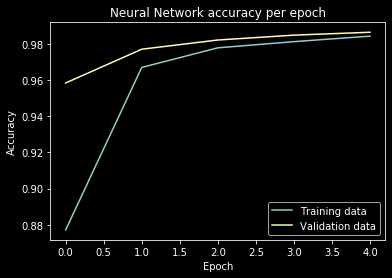

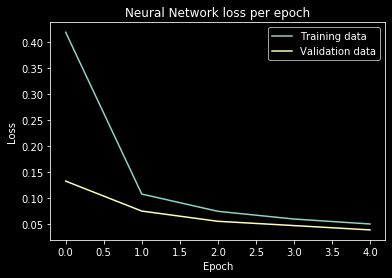

In [14]:
#Get accuracy for lenet
sequentialLoss, sequentialAccuracy = lenet.evaluate(testX, testY)
print('Lenet accuracy: ', sequentialAccuracy)
print('Lenet loss: ', sequentialLoss)

plt.style.use('dark_background')
plt.plot(lenetEpochHistory.history['acc'])
plt.plot(lenetEpochHistory.history['val_acc'])
plt.title('Neural Network accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training data', 'Validation data'])
plt.show()

plt.style.use('dark_background')
plt.plot(lenetEpochHistory.history['loss'])
plt.plot(lenetEpochHistory.history['val_loss'])
plt.title('Neural Network loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training data', 'Validation data'])
plt.show()

In [15]:
utils.find_layer_idx(lenet, 'vis')
#lenet.layers[9].get_weights()
#lenet.layers[9].get_weights()[0][0]
#len(lenet.layers[9].get_weights()[1])
#lenet.layers[9].get_weights()[1]

9

In [16]:
get_num_filters(lenet.layers[9])

10

In [17]:
names = [weight.name for layer in lenet.layers for weight in layer.weights]
weights = lenet.get_weights()

for name, weight in zip(names, weights):
    print(name, weight.shape)

conv2d_1/kernel:0 (5, 5, 1, 20)
conv2d_1/bias:0 (20,)
conv2d_2/kernel:0 (5, 5, 20, 50)
conv2d_2/bias:0 (50,)
dense_1/kernel:0 (2450, 500)
dense_1/bias:0 (500,)
vis/kernel:0 (500, 10)
vis/bias:0 (10,)


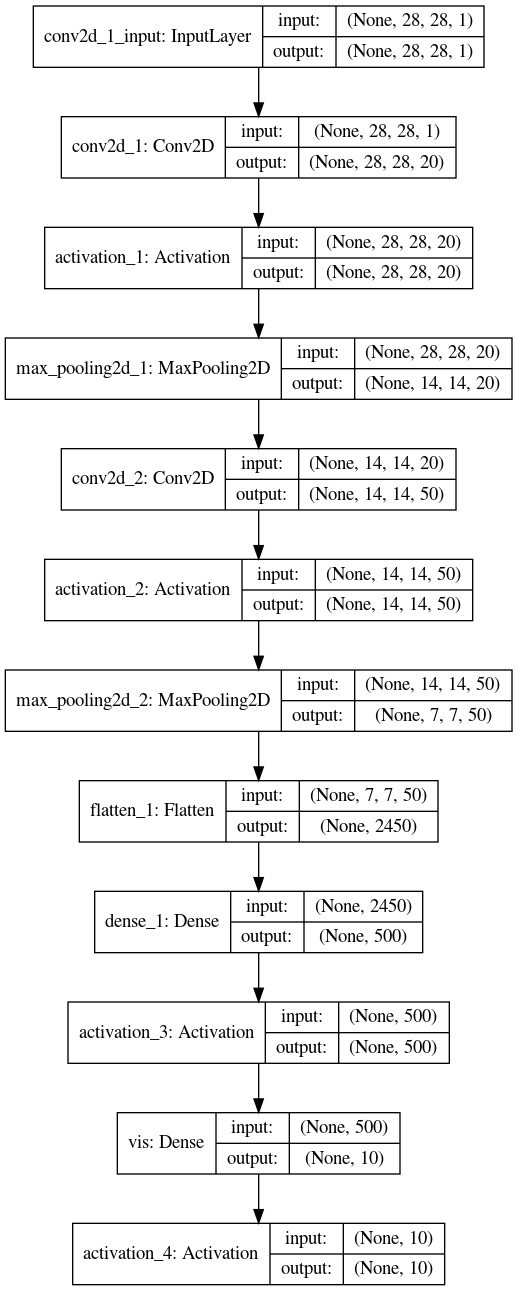

In [18]:
plot_model(lenet, to_file='model.png',show_shapes=True)

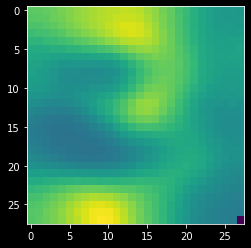

In [19]:
activation_map = visualize_activation(lenet,9,filter_indices=3)
activation_map = activation_map.reshape(28,28)
plt.imshow(activation_map,interpolation='nearest')

99.113754


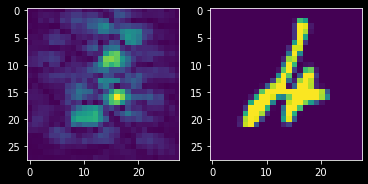

In [33]:
input_idx = 247
fig, ax = plt.subplots(nrows=1, ncols=2)
saliency_map = visualize_saliency(model = lenet,layer_idx = 9, filter_indices = np.argmax(testY[input_idx]), seed_input = testX[input_idx])
ax[0].imshow(saliency_map.reshape(28,28),interpolation='nearest')
ax[1].imshow(testX[input_idx].reshape(28,28))
print(np.sum(saliency_map))
plt.show()

In [34]:
intermediate_layer_model = keras.Model(inputs=lenet.input,
                                 outputs=lenet.get_layer("vis").output)
intermediate_output = intermediate_layer_model.predict(testX)[input_idx]
print(max(intermediate_output))
print(lenet.predict(testX)[input_idx])

7.6894264
[1.9046156e-05 1.1748307e-03 4.6738562e-01 4.4724634e-06 4.6422762e-01
 3.3012853e-05 6.6964515e-02 1.2849028e-04 6.2329214e-05 4.5124999e-08]


In [35]:
#Generate multiple activation_maps
activation_maps = []
for classifier in lenets:
    activation_maps.append(visualize_activation(classifier,9,filter_indices=3))

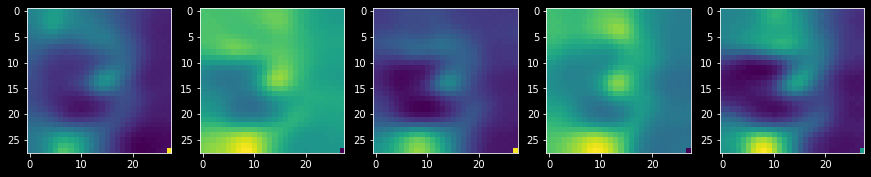

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=classifier_number, figsize = (15,15))
i = 0
for a_map in activation_maps:
    ax[i].imshow(a_map.reshape(28,28),interpolation='nearest')
    i = i+1

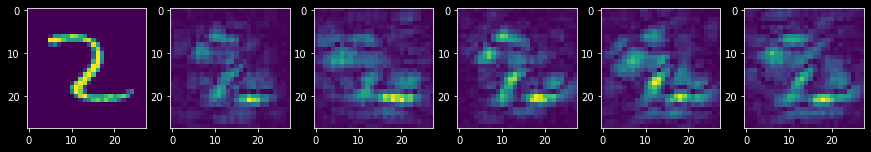

In [85]:
#Generate multiple activation_maps
input_idx = 2500
saliency_maps = []
predicted_classes = []
for classifier in lenets:
    saliency_maps.append(visualize_saliency(model = classifier,layer_idx = 9, filter_indices = np.argmax(testY[input_idx]), seed_input = testX[input_idx]))
    predicted_classes.append(np.argmax(classifier.predict(testX)[input_idx]))

image_saliency_maps = saliency_maps
fig, ax = plt.subplots(nrows=1, ncols=classifier_number+1, figsize = (15,15))
i = 1
for s_map in image_saliency_maps:
    ax[i].imshow(s_map.reshape(28,28),interpolation="nearest")
    i = i+1
ax[0].imshow(testX[input_idx].reshape(28,28))
plt.show()

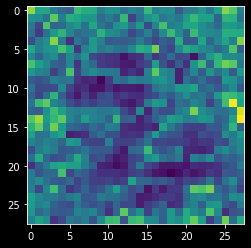

In [86]:
saliency_map_difference = np.std(saliency_maps,axis=0)/np.average(saliency_maps,axis=0)
plt.imshow(saliency_map_difference)
plt.show()

In [87]:
np.average(saliency_map_difference)

0.5746668

In [88]:
predicted_classes

[2, 2, 2, 2, 2]

In [30]:
idx = 0
for i in lenet.predict(testX):
    if (np.argmax(i) != np.argmax(testY[idx])):
        print(idx)
    idx = idx + 1

247
259
321
340
445
495
582
583
619
684
689
720
740
947
959
1014
1039
1112
1181
1182
1226
1242
1260
1319
1378
1393
1500
1522
1527
1530
1621
1681
1709
1721
1878
1901
2035
2098
2109
2130
2135
2182
2189
2272
2387
2406
2447
2488
2648
2654
2771
2896
2953
2995
3030
3073
3333
3422
3451
3503
3520
3534
3558
3597
3730
3762
3767
3796
3808
3811
3976
3985
4065
4078
4102
4176
4199
4224
4248
4265
4360
4536
4578
4601
4639
4671
4807
4823
4860
4874
4880
4956
5600
5649
5654
5842
5887
5937
5955
5972
5973
5981
5982
5985
5997
6011
6023
6059
6505
6555
6571
6572
6576
6597
6651
8062
8094
8408
8527
9009
9015
9587
9634
9642
9664
9679
9729
9768
9770
9779
9792
9811
9888
9904
